# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import lightgbm as lgbm
import plotly.offline as py
import scikitplot as skplt
import cvxpy as cp
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import stats
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, roc_auc_score, \
recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

In [2]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [3]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


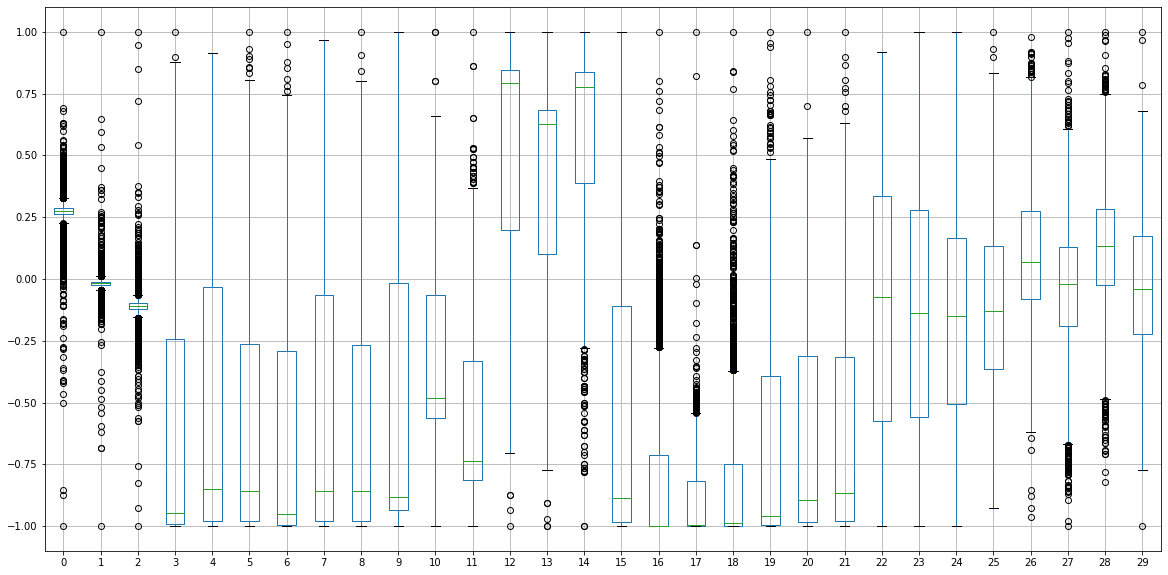

In [5]:
plt.figure(figsize=(20,10))
train_reduced = pd.DataFrame(X_train[:, :30])
train_reduced.boxplot()
plt.show()

> Судя по `boxplot` хотя бы для перых 30 фичей, данные содержат много выбрасов или, если быть более точным, сильно отклоняются от нормльного распределения. Про происхождение данных известноm что это записи некоторого датчика, усредненные с некоторым окном, поэтому в них не должно быть такого количества выбросов, как показывает boxplot. Возникает ощущение, что использование `StandartScale` не совсем удачное решение, на мой взгляд лучше использовать `MinMaxScaler`, так как `std` у некоторых фичей очень мало

> Использование `MinMaxScaler` оказалось оправданным, так как с ним оказалось **гораздо** проще подбирать гиперпараметры

In [6]:
print(X_train.shape)
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [7]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [8]:
pca = PCA(0.99)

In [9]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

Text(0, 0.5, 'Principal component 2')

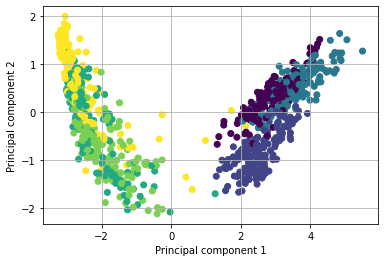

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

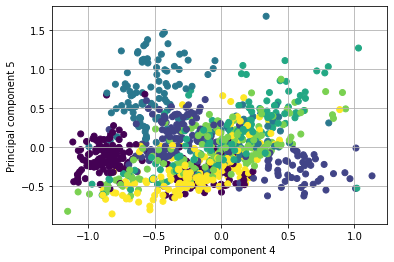

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [12]:
def report(true_labels, predictions, probs, title="Base"):
    print(f"{title} accuracy score {accuracy_score(y_test, y_pred)}")
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7))
    skplt.metrics.plot_confusion_matrix(true_labels, predictions, normalize=True, 
                                        ax=ax2, title=f"{title} Confusion Matrix")
    skplt.metrics.plot_roc(true_labels, probs, ax=ax1, figsize=(8,8), title=f"{title} ROC curve")
    plt.show()

In [13]:
random_state=42

In [14]:
train_set = lgbm.Dataset(data=X_train_pca, label=y_train)
test_set = lgbm.Dataset(data=X_test_pca, label=y_test)

Base accuracy score 0.9358669833729216


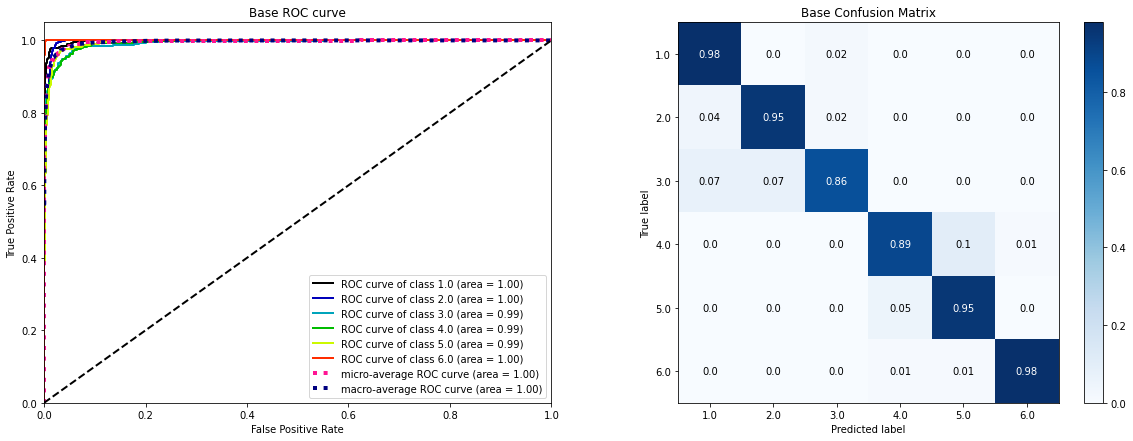

CPU times: user 39.5 s, sys: 587 ms, total: 40.1 s
Wall time: 5.79 s


In [15]:
%%time
lgbm_base = lgbm.LGBMClassifier()

lgbm_base.fit(X_train_pca, y_train)
y_pred = lgbm_base.predict(X_test_pca)
y_score = lgbm_base.predict_proba(X_test_pca)
report(y_test, y_pred, y_score)

> Мы видим, что при использовани `MinMaxScaler` даже без тюнинга параметров LightGBM выдает очень хорошие результаты. Для сравнения обучим модель на данных с `StandardScaler`. Так как LightGBM склонен переобучаться на маленьких датасетах. Это вызвано тем, что LightGBM в отличие, наприемр, от XGBoost, использует схему  Leaf-wise tree growth. Переобучение возникает, когда LightGBM имеет слишком гулбокие деревья, поэтому зафиксируем количество листьев `num_leaves=50` и добавим регуляризацию `l2`. Также возьмем достаточно большое `n_estimators=200`, при этом будем обучать модель на всей выборке. Для повышения скорости обучения, согласно рекомендации из документации к `lightgbm`, подберем с помощью `GridSearchCV` значения гиперпараметров `bagging_fraction` и `feature_fraction`

In [16]:
random_state = 42
np.random.seed(random_state)

In [17]:
gkf = StratifiedKFold(n_splits=5).split(X=X_train_pca, y=y_train)

param_grid = {
    "bagging_fraction": [0.2, 0.5, 0.8],
    "feature_fraction": [0.4, 0.6, 0.8],
    "reg_alpha": [0, 0.3, 0.6],
}

lgbm_clf = lgbm.LGBMClassifier(n_estimators=200, num_leaves=50, metric="multi_logloss", 
                               verbosity=50, seed=random_state)

gsearch = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=param_grid, 
                             cv=gkf, verbose=True, n_jobs=-1, scoring="accuracy")
lgb_model = gsearch.fit(X_train_pca, y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.5min finished


{'reg_alpha': 0, 'feature_fraction': 0.4, 'bagging_fraction': 0.5} 0.9115923731831279


Best accuracy score 0.9453681710213777


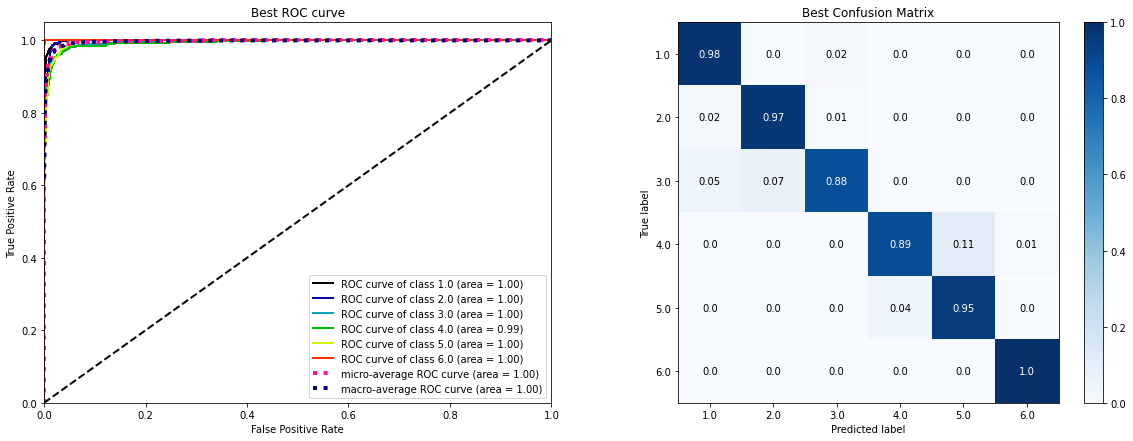

In [18]:
y_pred = lgb_model.predict(X_test_pca)
y_score = lgb_model.predict_proba(X_test_pca)
report(y_test, y_pred, y_score, "Best")

In [19]:
import plotly.express as px
cv_res = pd.DataFrame(gsearch.cv_results_["params"])
cv_res["time"] = gsearch.cv_results_["mean_fit_time"]
cv_res["score"] = gsearch.cv_results_["mean_test_score"]
cv_res["score"] = cv_res["score"].apply(lambda x: x * 100)
fig = px.scatter_3d(cv_res, x="feature_fraction", y="bagging_fraction", z="reg_alpha", 
                    color='score', hover_data=["time"])
fig.show()
fig = px.scatter_3d(cv_res, x="feature_fraction", y="bagging_fraction", z="reg_alpha", 
                    color='time', hover_data=["score"])
fig.show()

> Также для большего понимания того какие фичи дают главный вклад во время и в score, построим матрицу корреляции

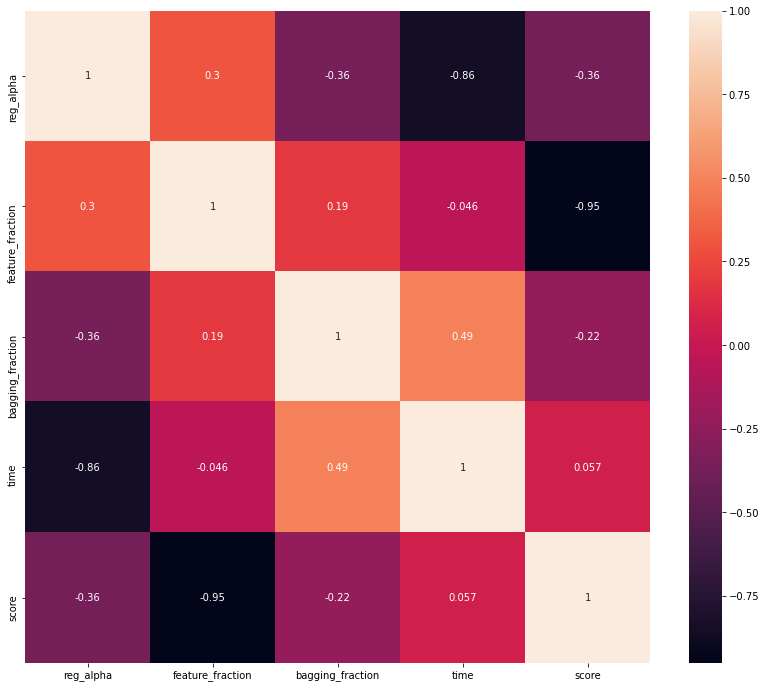

In [20]:
plt.figure(figsize=(14,12))
sns.heatmap(cv_res.corr(), annot=True)

> Мы видим, что фича `feature_fraction` сильно скоррелирована с `score`, в то же время, как и было написано в документации, `feature_fraction` и `bagging_fraction` обе хорошо скоррелированы с `time`.  Таким обарзом, можно еще несколько улучшить модель, запустив на ней `GridSearch` по  `feature_fraction`

In [21]:
gkf = StratifiedKFold(n_splits=5).split(X=X_train_pca, y=y_train)

param_grid = {
    "feature_fraction": np.linspace(0.1, 0.2, 4),
    "reg_alpha": np.linspace(0, 0.2, 4),
}

lgbm_clf = lgbm.LGBMClassifier(n_estimators=200, num_leaves=50, metric="multi_logloss", 
                               verbosity=50, bagging_fraction=0.1, seed=random_state)

gsearch = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, cv=gkf, verbose=True, n_jobs=-1, scoring="accuracy")
lgb_model = gsearch.fit(X_train_pca, y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.5min finished


{'feature_fraction': 0.2, 'reg_alpha': 0.0} 0.916352520613956


Best accuracy score 0.9528333898880217


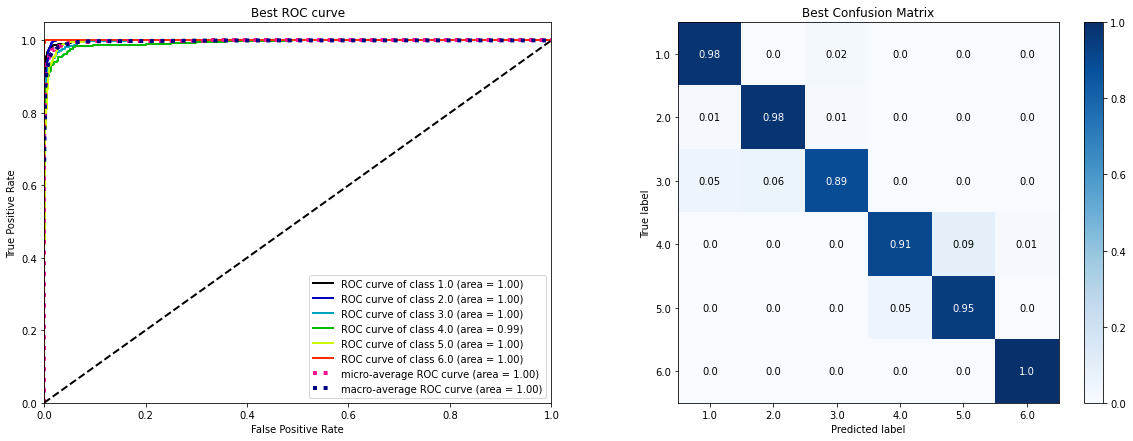

In [22]:
y_pred = lgb_model.predict(X_test_pca)
y_score = lgb_model.predict_proba(X_test_pca)
report(y_test, y_pred, y_score, "Best")

> Мы видим, что при использовани `MinMaxScaler` даже без тюнинга параметров LightGBM выдает очень хорошие результаты. Попробуем аналогичную схему с моделью, в которой использовался `StandardScaler` для предобработки данных. В данном случае гиперпарметры подобрать достаточно тяжело, поэтому остановимся на следующей модели (ее в будущем будем использовать для Blending)

In [23]:
scale_st = StandardScaler()
X_train_st = scale_st.fit_transform(X_train)
X_test_st = scale_st.transform(X_test)
X_train_st_unique = X_train_st[:, unique_columns]
X_test_st_unique = X_test_st[:, unique_columns]
pca_st = PCA(0.99)
X_train_st_pca = pca_st.fit_transform(X_train_st_unique)
X_test_st_pca = pca_st.transform(X_test_st_unique)

Best StandardScaler accuracy score 0.9355276552426196


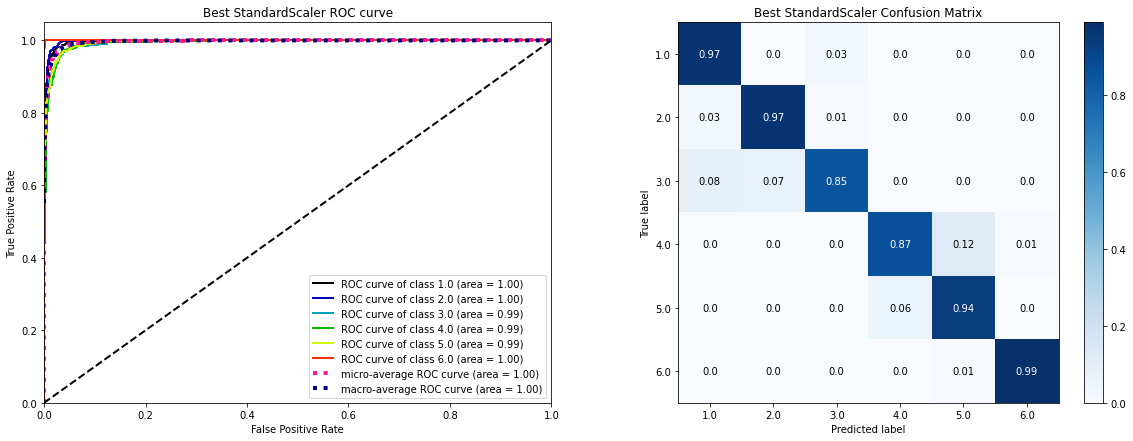

CPU times: user 1min 26s, sys: 1.72 s, total: 1min 28s
Wall time: 12.4 s


In [24]:
%%time
lgbm_clf_st = lgbm.LGBMClassifier(n_estimators=450, num_leaves=250, learning_rate=0.06, metric="multi_logloss", 
                                  bagging_fraction=0.2, feature_fraction=0.2, reg_alpha=0.2,
                                  reg_lambda=0.4, verbosity=1, seed=random_state)

lgb_model_st = lgbm_clf_st.fit(X_train_st_pca, y_train)
y_pred = lgb_model_st.predict(X_test_st_pca)
y_score = lgb_model_st.predict_proba(X_test_st_pca)
report(y_test, y_pred, y_score, "Best StandardScaler")

> Также попробуем обучить `CatBoost` и подберем для него гиперпараметры

In [25]:
cb_clf = CatBoostClassifier(verbose=200)
grid = {'learning_rate': [0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5]}

grid_search_result = cb_clf.grid_search(grid, 
                                        X=X_train_pca, 
                                        y=y_train,
                                        verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0851466	best: 0.0851466 (0)	total: 16s	remaining: 47.9s
3:	loss: 0.0816887	best: 0.0772843 (2)	total: 2m 14s	remaining: 0us
Estimating final quality...


In [26]:
cb_clf = CatBoostClassifier(**grid_search_result["params"])
cb_clf.fit(X_train_pca, y_train, verbose=200)

0:	learn: 1.5324638	total: 144ms	remaining: 2m 24s
200:	learn: 0.0848634	total: 12.3s	remaining: 49s
400:	learn: 0.0385072	total: 24.9s	remaining: 37.1s
600:	learn: 0.0215961	total: 36.5s	remaining: 24.2s
800:	learn: 0.0138109	total: 47.2s	remaining: 11.7s
999:	learn: 0.0094563	total: 58s	remaining: 0us


Best CatBoost accuracy score 0.9501187648456056


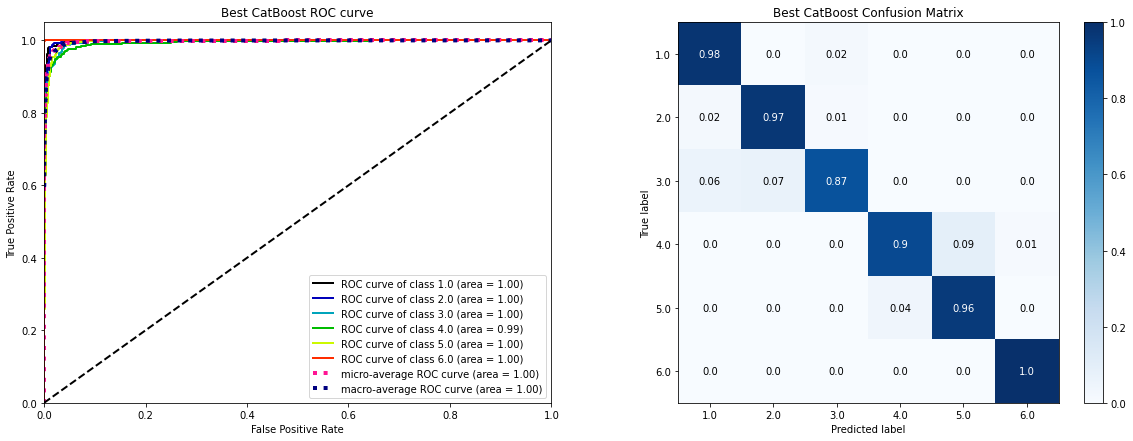

In [27]:
y_pred = cb_clf.predict(X_test_pca)
y_score = cb_clf.predict_proba(X_test_pca)
report(y_test, y_pred, y_score, "Best CatBoost")

> `CatBoost` оказался очень неплох даже в стандартной конфигурации, но он слишком долго учится, поэтому подбор гиперпараметров с ним затруднителен, поэтому остановимся на достигнутом и не будем тренировать модель с данными `StandardScaler` (опять же полученная модель будет имспользована в Blending)

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [28]:
from sklearn.base import BaseEstimator

In [29]:
class BlendingAveragedModels(BaseEstimator):
    def __init__(self, base_models, holdout_pct=0.2):
        self.base_models = base_models
        self.holdout_pct = holdout_pct
        
    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.holdout_pct)
        self.num_models = len(self.base_models)
        preds = np.zeros((X_val.shape[0], self.num_models))
        for i, model in enumerate(self.base_models):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            preds[:, i] = y_pred.reshape(-1)
        rho = cp.Variable(self.num_models)
        objective = cp.Minimize(cp.sum_squares(preds @ rho - y_val))
        constraints = [0 <= rho, rho <= 1, cp.sum(rho) == 1]
        prob = cp.Problem(objective, constraints)
        _ = prob.solve()
        self.rho = rho.value
    
    def predict(self, X):
        meta_features = np.dstack([
            model.predict_proba(X) for model in self.base_models
        ])        
        return np.argmax(meta_features @ self.rho, axis=1) + 1
    def predict_proba(self, X):
        meta_features = np.dstack([
            model.predict_proba(X) for model in self.base_models
        ])        
        return meta_features @ self.rho

In [30]:
from sklearn.pipeline import Pipeline

In [31]:
models = [
    Pipeline([
        ("minmax", MinMaxScaler()),
        ("pca", PCA(0.99)),
        ("lgbm", lgbm.LGBMClassifier(n_estimators=200, num_leaves=50, metric="multi_logloss", 
                                     verbosity=50, reg_alpha=0.6, feature_fraction=0.2, seed=random_state))
    ]),
    Pipeline([
        ("standard", StandardScaler()),
        ("lgbm", lgbm.LGBMClassifier(n_estimators=450, num_leaves=250, learning_rate=0.06, metric="multi_logloss", 
                                     bagging_fraction=0.2, feature_fraction=0.2, reg_alpha=0.2,
                                     reg_lambda=0.4, verbosity=1, seed=random_state))
    ]),
    Pipeline([
        ("minmax", MinMaxScaler()),
        ("pca", PCA(0.99)),
        ("lgbm", lgbm.LGBMClassifier(n_estimators=500, num_leaves=200, metric="multi_logloss",
                                     verbosity=50, reg_alpha=0.4, bagging_fraction=0.4, seed=random_state))
    ]),
    Pipeline([
        ("minmax", MinMaxScaler()),
        ("pca", PCA(0.99)),
        ("cb", CatBoostClassifier(**grid_search_result["params"], verbose=200))
    ])
]

In [32]:
blending_model1 = BlendingAveragedModels(models)
blending_model1.fit(X_train, y_train)

0:	learn: 1.5378873	total: 118ms	remaining: 1m 57s
200:	learn: 0.0812482	total: 10.3s	remaining: 41.1s
400:	learn: 0.0351725	total: 22.1s	remaining: 33.1s
600:	learn: 0.0196968	total: 33.2s	remaining: 22s
800:	learn: 0.0123809	total: 45s	remaining: 11.2s
999:	learn: 0.0086387	total: 59.5s	remaining: 0us


Base accuracy score 0.9429928741092637


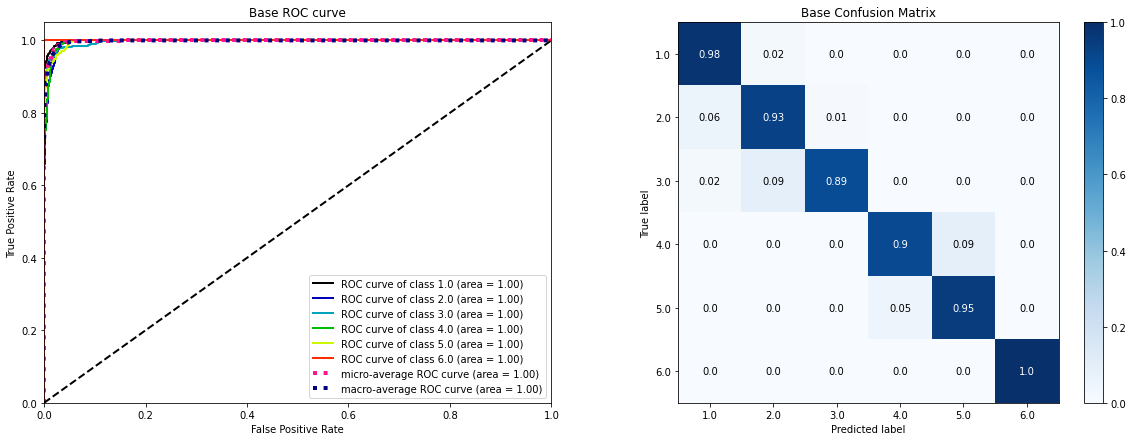

In [33]:
y_score = blending_model1.predict_proba(X_test)
y_pred = blending_model1.predict(X_test)
report(y_test, y_pred, y_score)

> Мы получили результат на уровне с тем, что показал `lightgbm` и `catboost`, если также корректно подобрать гиперпараметры, то можно ожидать еще больших значений. К сожалению подбирать их довольно долгий процесс, так как параметров очень много, поэтому остановимся на достигнутом результате.

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

> Сравним `feature importance` для лучшей модели из LightGBM и лучшей модели из CatBoost. К сожалению сравнить их обоих с моделью LightGBM с предобработкой `StandardScaler` в простейшем случае не получится так как в разных случаях `PCA` отбирает разные фичи. Сделаем сравнение для `CatBoost` и `LightGBM`. Используем один технический трюк: вопспользуемся `MinMaxScaler` чтобы привести значения `feature importance` в одну шкалу, сохранив при этом их распределния

In [34]:
def compare_models_feature_imp(model1, model2, title=""):
    imp1 = model1.feature_importances_
    imp2 = model2.feature_importances_
    imp1 = MinMaxScaler().fit_transform(imp1.reshape(-1, 1)).reshape(-1)
    imp2 = MinMaxScaler().fit_transform(imp2.reshape(-1, 1)).reshape(-1)
    df1 = pd.DataFrame(zip(imp1, [f"Column {i}" for i in range(imp1.shape[0])]), 
                       columns=['Value', 'Feature']) \
            .sort_values(by=["Value"], ascending=False)[:20]
    df1["Model"] = "LightGBM"
    df2 = pd.DataFrame(zip(imp2, [f"Column {i}" for i in range(imp2.shape[0])]), 
                       columns=['Value', 'Feature']) \
            .sort_values(by=["Value"], ascending=False)[:20]
    df2["Model"] = "Catboost"
    feature_imp = pd.concat([df1, df2])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", hue="Model", data=feature_imp.sort_values(by=["Value", "Feature"], ascending=False))
    plt.grid()
    plt.title(title)
    return feature_imp

In [35]:
best_lgbm = lgb_model.best_estimator_
best_lgbm_st = lgb_model_st

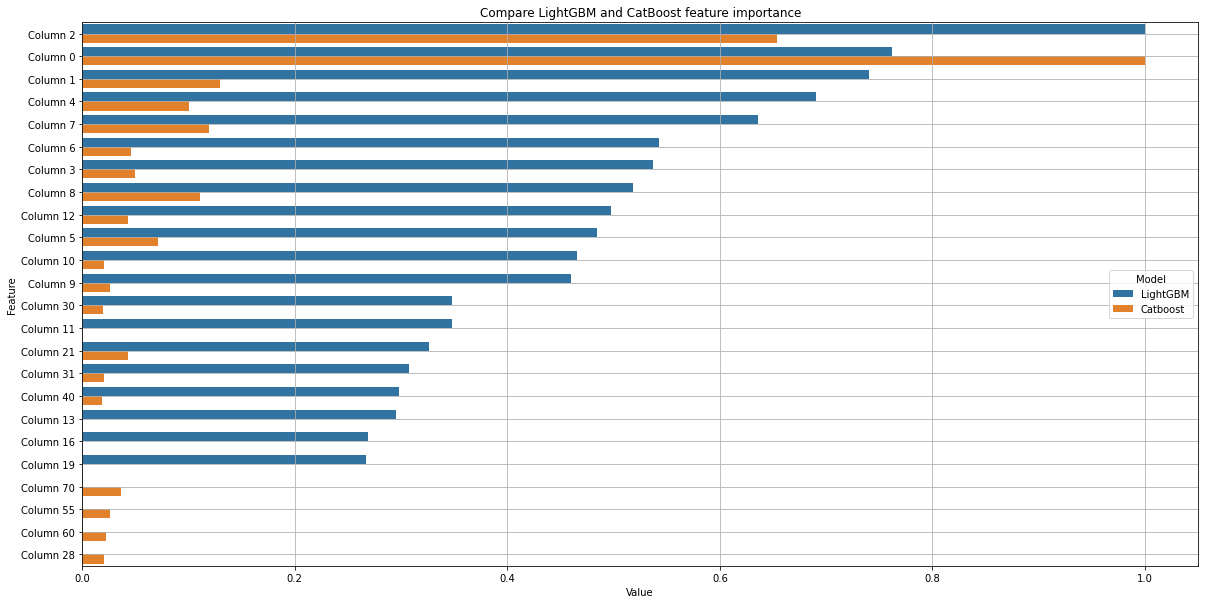

In [36]:
df = compare_models_feature_imp(best_lgbm, cb_clf, title="Compare LightGBM and CatBoost feature importance")

> Можем видеть, что наибольший вклад для обоих моделей делают одни и те же фичи, а именно фичи с первыми номерами

In [37]:
def model_feature_imp(model, title=""):
    imp = model.feature_importances_
    imp = MinMaxScaler().fit_transform(imp.reshape(-1, 1)).reshape(-1)
    index = [f"Coulumn {i}" for i in range(imp.shape[0])]
    feature_imp = pd.DataFrame(zip(imp, index), columns=['Value', 'Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50])
    plt.grid()
    plt.title(title)

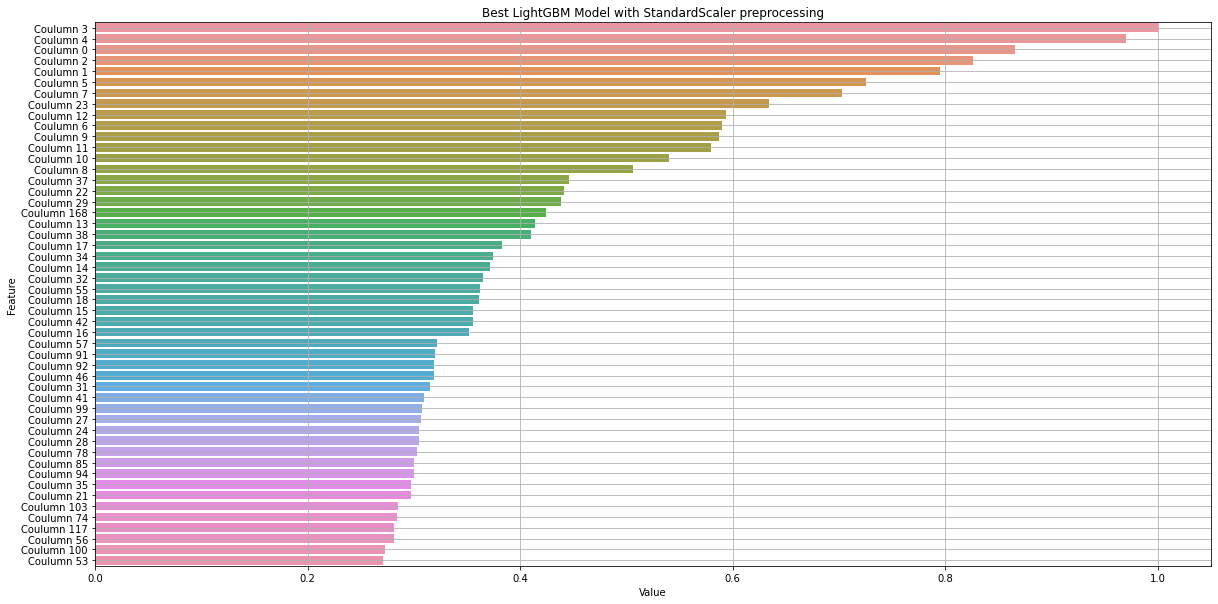

In [38]:
best_lgbm = lgb_model.best_estimator_
best_lgbm_st = lgb_model_st
model_feature_imp(best_lgbm_st, title="Best LightGBM Model with StandardScaler preprocessing")

> Теперь так с помощью `shap` сравним `feature importance` для всех трех моделей. Для этого зададим для каждой модели pipeline, включающий в себя предобработку данных, PCA и саму модель

In [39]:
cb_pipe = Pipeline([
    ("minmax", MinMaxScaler()),
    ("pca", PCA(0.99)),
    ("cb", CatBoostClassifier(**grid_search_result["params"], verbose=200))
])
lgbm_st_pipe = Pipeline([
    ("standard", StandardScaler()),
    ("pca", PCA(0.99)),
    ("lgbm", lgbm.LGBMClassifier(n_estimators=450, num_leaves=250, learning_rate=0.06, metric="multi_logloss", 
                                 bagging_fraction=0.2, feature_fraction=0.2, reg_alpha=0.2,
                                 reg_lambda=0.4, verbosity=1, seed=random_state))
])
lgbm_pipe = Pipeline([
    ("standard", MinMaxScaler()),
    ("pca", PCA(0.99)),
    ("lgbm", lgbm.LGBMClassifier(n_estimators=200, num_leaves=50, metric="multi_logloss", 
                                 verbosity=50, bagging_fraction=0.1, feature_fraction=0.2, 
                                 seed=random_state))
])

In [40]:
import shap

In [41]:
lgbm_pipe.fit(X_train, y_train)
shap.initjs()

In [54]:
explainer = shap.KernelExplainer(lgbm_pipe.predict_proba, shap.sample(X_train, 80))
shap_values = explainer.shap_values(shap.sample(X_test, 50), l1_reg="aic")

In [55]:
lgbm_st_pipe.fit(X_train, y_train)
shap.initjs()

In [56]:
explainer_st = shap.KernelExplainer(lgbm_st_pipe.predict_proba, shap.sample(X_train, 80))
shap_values_st = explainer_st.shap_values(shap.sample(X_test, 50), l1_reg="aic")

In [57]:
cb_pipe.fit(X_train, y_train)
shap.initjs()

0:	learn: 1.5404985	total: 117ms	remaining: 1m 56s
200:	learn: 0.0834862	total: 11.4s	remaining: 45.4s
400:	learn: 0.0380215	total: 24.1s	remaining: 36.1s
600:	learn: 0.0211646	total: 36.9s	remaining: 24.5s
800:	learn: 0.0136462	total: 48.4s	remaining: 12s
999:	learn: 0.0093983	total: 59.8s	remaining: 0us


In [58]:
explainer_cb = shap.KernelExplainer(cb_pipe.predict_proba, shap.sample(X_train, 80))
shap_values_cb = explainer_cb.shap_values(shap.sample(X_test, 50), l1_reg="aic")

In [59]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

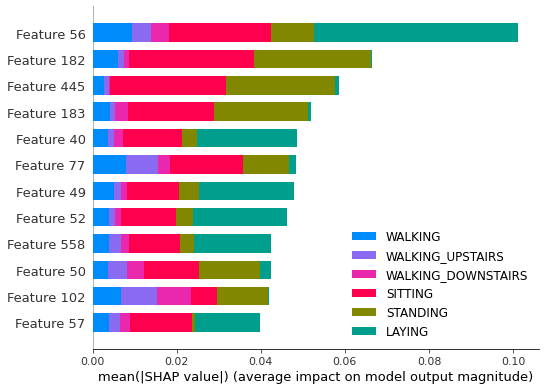

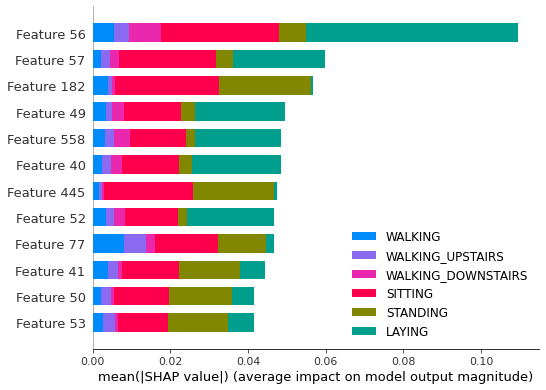

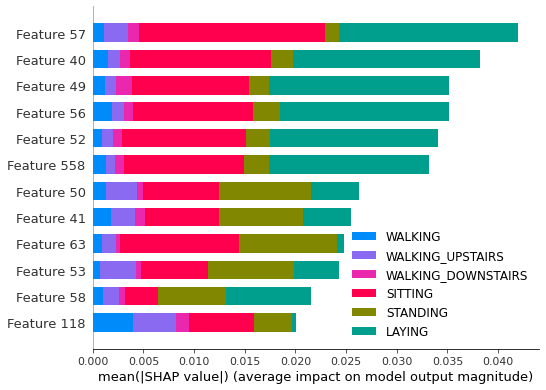

In [60]:
shap.summary_plot(shap_values_cb, X_test, max_display=12, 
                  class_inds=[i for i in range(6)], class_names=[activity_labels[i] for i in range(1, 7)])
shap.summary_plot(shap_values, X_test, max_display=12, 
                  class_inds=[i for i in range(6)], class_names=[activity_labels[i] for i in range(1, 7)])
shap.summary_plot(shap_values_st, X_test, max_display=12, 
                  class_inds=[i for i in range(6)], class_names=[activity_labels[i] for i in range(1, 7)])

> Можно видеть, что лучшие модлели, а именно `LightGBM` с `MinMaxScaler` и `CatBoost` очень походи по первым 10 значимым фичам, они обе выделают фичи $182, 40, 77, 455$. Кроме того все три модели выделяют фичи $49, 52, 40, 558$. Кроме того при использовании `SatndardScale` распределдения влияния на предсказания модели по фичам более равномерное, нежели в случае `MinMaxScaler`. Также можно наблюдать, что значимые фичи в основном лежат в отрезке [30, 70], это сможет говорить о том, что либо именно в этот период происходили наиболее важные события с датчиком, либо наблюдается переобучение, так как, если, человек будет, например, лежать все время записи, то это приведет к тому, что движение в любое время должно давать примерно одинаковый вклад в классификацию движения. Исходя из следующего графика видно, что в отрезке [30,70] все-таки происходило что-то действительно важное

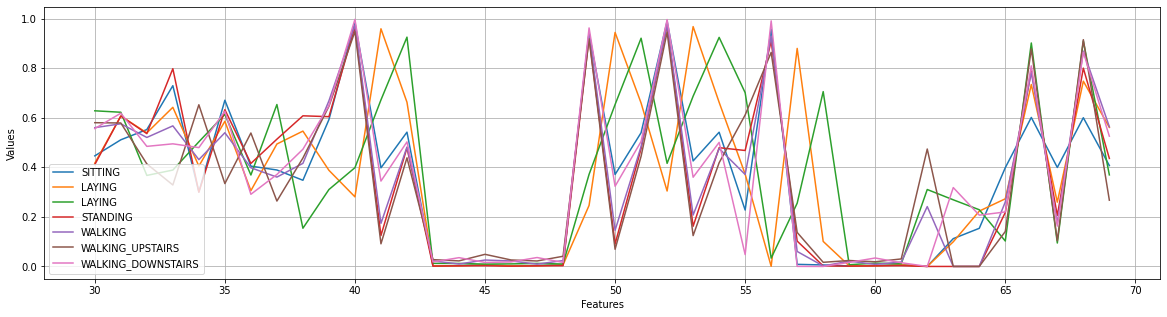

In [61]:
plt.figure(figsize=(20,5))
plt.plot(range(30, 70), X_train[400, 30:70], label=f"{activity_labels[y_train[400]]}")
plt.plot(range(30, 70), X_train[900, 30:70], label=f"{activity_labels[y_train[900]]}")
plt.plot(range(30, 70), X_train[2300, 30:70], label=f"{activity_labels[y_train[2300]]}")
plt.plot(range(30, 70), X_train[200, 30:70], label=f"{activity_labels[y_train[200]]}")
plt.plot(range(30, 70), X_train[100, 30:70], label=f"{activity_labels[y_train[100]]}")
plt.plot(range(30, 70), X_train[500, 30:70], label=f"{activity_labels[y_train[500]]}")
plt.plot(range(30, 70), X_train[800, 30:70], label=f"{activity_labels[y_train[800]]}")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

> Негативный вклад вносит фичи с номерами в окрестности 559, так как, кажется, что для чистоты эксперемента основное движени должно быть совершено где-то в середине времени, по преведнному ниже графику видно, что фичи имеющие номер больший, чем $550$ действительно вносят шум. В конце так и воовсе у всех классов граяик одинаковый

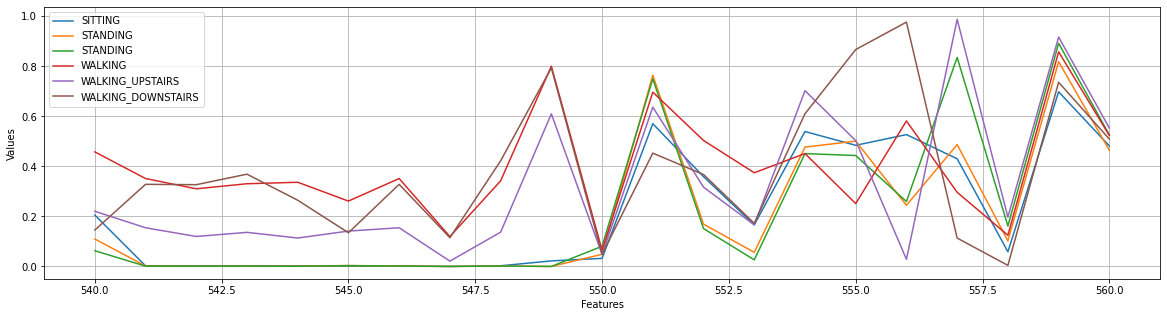

In [62]:
plt.figure(figsize=(20,5))
plt.plot(range(540, X_train.shape[1]), X_train[400, 540:], label=f"{activity_labels[y_train[400]]}")
plt.plot(range(540, X_train.shape[1]), X_train[1000, 540:], label=f"{activity_labels[y_train[1000]]}")
plt.plot(range(540, X_train.shape[1]), X_train[200, 540:], label=f"{activity_labels[y_train[200]]}")
plt.plot(range(540, X_train.shape[1]), X_train[100, 540:], label=f"{activity_labels[y_train[100]]}")
plt.plot(range(540, X_train.shape[1]), X_train[500, 540:], label=f"{activity_labels[y_train[500]]}")
plt.plot(range(540, X_train.shape[1]), X_train[800, 540:], label=f"{activity_labels[y_train[800]]}")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

> Наконец проблемы с различением $3, 4$ классов вызваны тем, что у них очень похожие графики. Не совсем понятно как так ставился эксперемент, что графики оказались настолько похожи

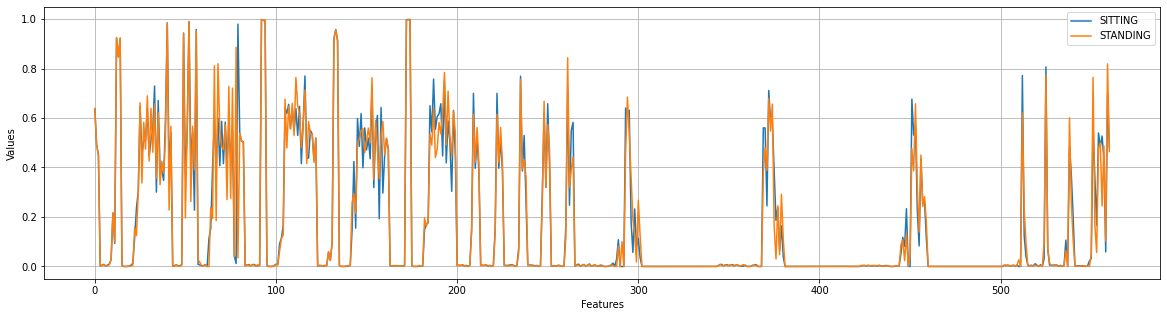

In [63]:
plt.figure(figsize=(20,5))
plt.plot(X_train[400], label=f"{activity_labels[y_train[400]]}")
plt.plot(X_train[1000], label=f"{activity_labels[y_train[1000]]}")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()